In [0]:
from google.colab import drive

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!ls "/content/drive/My Drive"

 Barrons-800.gdoc
 Classroom
'Colab Notebooks'
 Content-Based-Video-Search-TCS.zip
'datasets links'
 fra.txt
'[GigaCourse.com] Udemy - Deep Learning and Computer Vision A-Z™ OpenCV, SSD & GANs'
 glove.6B.100d.txt
 gre
'How to get started with Drive.pdf'
 Icons
 ipgm_project
 magoos
'Mike And Dave Need Wedding Dates (2016) [1080p] [YTS.AG]'
'ml resume'
 project
'Research papers (final-year project).gsheet'
 TCS_PROJECT
 Untitled0.ipynb
'Untitled document.gdoc'
'Untitled spreadsheet.gsheet'
 videos
 YOLOv3-Object-Detection-with-OpenCV


In [0]:
# # https://deeplearningcourses.com/c/deep-learning-advanced-nlp
# get the data at: http://www.manythings.org/anki/
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

import os, sys

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

import keras.backend as K
# if len(K.tensorflow_backend._get_available_gpus()) > 0:
#   from keras.layers import CuDNNLSTM as LSTM
#   from keras.layers import CuDNNGRU as GRU

In [0]:
# some config
BATCH_SIZE = 64  # Batch size for training.
EPOCHS = 40  # Number of epochs to train for.
LATENT_DIM = 256  # Latent dimensionality of the encoding space.
NUM_SAMPLES = 10000  # Number of samples to train on.
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

# Where we will store the data
input_texts = [] # sentence in original language
target_texts = [] # sentence in target language
target_texts_inputs = [] # sentence in target language offset by 1


In [4]:

# load in the data
# download the data at: http://www.manythings.org/anki/
t = 0
for line in open('/content/drive/My Drive/fra.txt'):
  # only keep a limited number of samples
  t += 1
  if t > NUM_SAMPLES:
    break

  # input and target are separated by tab
  if '\t' not in line:
    continue

  # split up the input and translation
  input_text, translation, *rest = line.rstrip().split('\t')

  # make the target input and output
  # recall we'll be using teacher forcing
  target_text = translation + ' <eos>'
  target_text_input = '<sos> ' + translation

  input_texts.append(input_text)
  target_texts.append(target_text)
  target_texts_inputs.append(target_text_input)
print("num samples:", len(input_texts))



num samples: 10000


In [5]:
#  tokenize the inputs
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

# determine maximum length input sequence
max_len_input = max(len(s) for s in input_sequences)

Found 2146 unique input tokens.


In [6]:
# tokenize the outputs
# don't filter out special characters
# otherwise <sos> and <eos> won't appear
tokenizer_outputs = Tokenizer(num_words=MAX_NUM_WORDS, filters='')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs) # inefficient, oh well
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

# store number of output words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1

# determine maximum length output sequence
max_len_target = max(len(s) for s in target_sequences)



Found 5754 unique output tokens.


In [7]:
# pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])

decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')



encoder_inputs.shape: (10000, 5)
encoder_inputs[0]: [ 0  0  0  0 15]
decoder_inputs[0]: [ 2 57  4  0  0  0  0  0  0  0  0]
decoder_inputs.shape: (10000, 11)


In [13]:

# store all the pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open('/content/drive/My Drive/glove.6B.100d.txt') as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))




Loading word vectors...
Found 400000 word vectors.


In [14]:

# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
  if i < MAX_NUM_WORDS:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector





Filling pre-trained embeddings...


In [0]:
# create embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_len_input,
  # trainable=True
)


In [0]:
# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
decoder_targets_one_hot = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)


In [0]:
# assign the values
for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    if word != 0:
      decoder_targets_one_hot[i, t, word] = 1




In [18]:
decoder_targets_one_hot.shape

(10000, 11, 5755)

In [19]:
##### build the model #####
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
print(x.shape)
encoder = LSTM(
  LATENT_DIM,
  return_state=True,
  dropout=0.5 # dropout not available on gpu
)
# print(encoder.shape)
encoder_outputs, h, c = encoder(x)
print(encoder_outputs.shape)
print(h.shape)
print(c.shape)

# encoder_outputs, h = encoder(x) #gru

# keep only the states to pass into decoder
encoder_states = [h, c]
# print(encoder_states.shape)
# encoder_states = [state_h] # gru

# Set up the decoder, using [h, c] as initial state.
decoder_inputs_placeholder = Input(shape=(max_len_target,))

# this word embedding will not use pre-trained vectors
# although you could
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)
print(decoder_inputs_x)
# since the decoder is a "to-many" model we want to have
# return_sequences=True
decoder_lstm = LSTM(
  LATENT_DIM,
  return_sequences=True,
  return_state=True,
  # dropout=0.5 # dropout not available on gpu
)
decoder_outputs, _, _ = decoder_lstm(
  decoder_inputs_x,
  initial_state=encoder_states
)


(None, 5, 100)
(None, 256)
(None, 256)
(None, 256)
Tensor("embedding_2/embedding_lookup/Identity_1:0", shape=(None, 11, 100), dtype=float32)


In [20]:
# final dense layer for predictions
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
# print(decoder_dense.shape)
print(decoder_outputs.shape)

(None, 11, 5755)


In [0]:
# Create the model object
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)


In [0]:

def custom_loss(y_true, y_pred):
  # both are of shape N x T x K
  mask = K.cast(y_true > 0, dtype='float32')
  out = mask * y_true * K.log(y_pred)
  return -K.sum(out) / K.sum(mask)



In [0]:
def acc(y_true, y_pred):
  # both are of shape N x T x K
  targ = K.argmax(y_true, axis=-1)
  pred = K.argmax(y_pred, axis=-1)
  correct = K.cast(K.equal(targ, pred), dtype='float32')

  # 0 is padding, don't include those
  mask = K.cast(K.greater(targ, 0), dtype='float32')
  n_correct = K.sum(mask * correct)
  n_total = K.sum(mask)
  return n_correct / n_total


In [0]:
model.compile(optimizer='adam', loss=custom_loss, metrics=[acc])


In [25]:
r = model.fit(
  [encoder_inputs, decoder_inputs], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2,
)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 8000 samples, validate on 2000 samples
Epoch 1/40
8000/8000 [==============================] - 14s 2ms/step - loss: 5.6565 - acc: 0.2603 - val_loss: 5.3085 - val_acc: 0.2491
Epoch 2/40
8000/8000 [==============================] - 12s 1ms/step - loss: 4.6370 - acc: 0.2900 - val_loss: 5.1175 - val_acc: 0.2626
Epoch 3/40
8000/8000 [==============================] - 12s 1ms/step - loss: 4.2876 - acc: 0.3145 - val_loss: 4.9381 - val_acc: 0.2971
Epoch 4/40
8000/8000 [==============================] - 12s 1ms/step - loss: 3.9433 - acc: 0.3665 - val_loss: 4.7624 - val_acc: 0.3267
Epoch 5/40
8000/8000 [==============================] - 12s 1ms/step - loss: 3.6758 - acc: 0.4056 - val_loss: 4.6571 - val_acc: 0.3431
Epoch 6/40
8000/8000 [==============================] - 12s 1ms/step - loss: 3.4438 - acc: 0.4346 - val_loss: 4.5931 - val_acc: 0.3592
Epoch 7/40
8000/8000 [==============================] - 12s 1ms/step - loss: 3.2334 - acc: 0.4574 - val_loss: 4.5109 - val_acc: 0.3731
Epoch 8

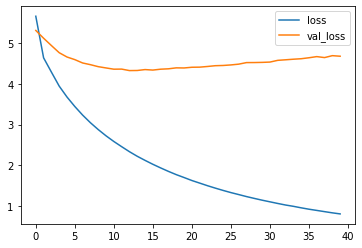

In [26]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [27]:
# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

KeyError: ignored

In [0]:
# Save model
model.save('s2s.h5')

In [0]:
##### Make predictions #####
# As with the poetry example, we need to create another model
# that can take in the RNN state and previous word as input
# and accept a T=1 sequence.

# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# decoder_states_inputs = [decoder_state_input_h] # gru

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# this time, we want to keep the states too, to be output
# by our sampling model
decoder_outputs, h, c = decoder_lstm(
  decoder_inputs_single_x,
  initial_state=decoder_states_inputs
)
# decoder_outputs, state_h = decoder_lstm(
#   decoder_inputs_single_x,
#   initial_state=decoder_states_inputs
# ) #gru
decoder_states = [h, c]
# decoder_states = [h] # gru
decoder_outputs = decoder_dense(decoder_outputs)


In [0]:
# The sampling model
# inputs: y(t-1), h(t-1), c(t-1)
# outputs: y(t), h(t), c(t)
decoder_model = Model(
  [decoder_inputs_single] + decoder_states_inputs, 
  [decoder_outputs] + decoder_states
)

# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}


In [0]:
def decode_sequence(input_seq):
  # Encode the input as state vectors.
  states_value = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))

  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
  target_seq[0, 0] = word2idx_outputs['<sos>']

  # if we get this we break
  eos = word2idx_outputs['<eos>']

  # Create the translation
  output_sentence = []
  for _ in range(max_len_target):
    output_tokens, h, c = decoder_model.predict(
      [target_seq] + states_value
    )
    # output_tokens, h = decoder_model.predict(
    #     [target_seq] + states_value
    # ) # gru

    # Get next word
    idx = np.argmax(output_tokens[0, 0, :])

    # End sentence of EOS
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = idx

    # Update states
    states_value = [h, c]
    # states_value = [h] # gru

  return ' '.join(output_sentence)


In [32]:
while True:
  # Do some test translations
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]
  translation = decode_sequence(input_seq)
  print('-')
  print('Input:', input_texts[i])
  print('Translation:', translation)

  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break

-
Input: I'm happy, too.
Translation: je suis également affairée.
Continue? [Y/n]Y
-
Input: I didn't look.
Translation: je n'ai pas regardé.
Continue? [Y/n]Y
-
Input: May I come in?
Translation: puis-je entrer ?
Continue? [Y/n]Y
-
Input: I'm involved.
Translation: je suis impliquée.
Continue? [Y/n]Y
-
Input: Who is there?
Translation: qui est là ?
Continue? [Y/n]Y
-
Input: How's it going?
Translation: comment cela se passe-t-il ?
Continue? [Y/n]n
